Compiling and post-processing water track data

In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd
import numpy as np
import glob

import matplotlib
matplotlib.rcParams.update({"pdf.fonttype":42})

# Import and organize field data

## Upper Kuparuk (Toolik)

In [2]:
uk_data = {}
# Compile all the data and melt it

p = Path(f'./upper_kuparuk_data/wts/')

wt_list = [f.stem for f in Path.glob(p, 'wt*.csv')]

for i, wt in enumerate(wt_list):
    df = pd.read_csv(f'./upper_kuparuk_data/wts/{wt}.csv')

    df['time'] = pd.to_datetime(df['TIMESTAMP'],format="%m/%d/%y %H:%M")
    df.index = df['time']
    
    # https://pandas.pydata.org/docs/reference/api/pandas.melt.html
    df_melt = pd.melt(df.drop('TIMESTAMP', axis=1), id_vars=['time'])

    df_melt['wt'] = wt

    # https://stackoverflow.com/questions/14745022/how-to-split-a-dataframe-string-column-into-two-columns

    df_melt[['loc', 'depth']] = df_melt['variable'].str.split('_', n=1, expand=True)

    df_melt['depth'] = df_melt['depth'].astype('float')

    # df_melt = df_melt.sort_values(by='time')

    

    if i == 0:
        df_save = df_melt
    try:
        # df_save = pd.merge(df_save, df_melt, on='time', how='outer')
        # issue with inconsistent timestamps??
        df_save = pd.concat([df_save, df_melt]).reset_index().drop(columns='level_0')
    except KeyError:
        df_save = pd.concat([df_save, df_melt]).reset_index()

uk_data['time_series'] = df_save.reset_index().drop(columns='level_0')

In [3]:
# Generate site-specific list of depths
uk_data['depth_list'] = list(df_save['depth'].unique())


In [4]:
def resample_and_plot_1D(wt_number, resample, year=None, plot=True, thin=1):
    wt = uk_data['time_series'][uk_data['time_series']['wt']==wt_number]

    wt_in = wt[wt['loc']=='in']
    wt_out = wt[wt['loc']=='out']

    if year is not None:

        if wt_in.query(f'{year}0101 < time < {year}1231').empty:
            print('No data for that time')
            return None, None
        else:
            resampled_in = wt_in.query(f'{year}0101 < time < {year}1231').drop(['variable','wt','loc'], axis=1).groupby('depth').resample(resample, on='time').mean().droplevel(level=0).reset_index()
            resampled_out = wt_out.query(f'{year}0101 < time < {year}1231').drop(['variable','wt','loc'], axis=1).groupby('depth').resample(resample, on='time').mean().droplevel(level=0).reset_index()


    else: 
        resampled_in = wt_in.drop(['variable','wt','loc'], axis=1).groupby('depth').resample(resample, on='time').mean().droplevel(level=0).reset_index()
        resampled_out = wt_out.drop(['variable','wt','loc'], axis=1).groupby('depth').resample(resample, on='time').mean().droplevel(level=0).reset_index()

    if plot==True:
        cmap = plt.get_cmap('gist_rainbow')
        cmap_list = cmap(np.linspace(0.0, 1.0, len(resampled_in['time'].unique())))

        fig, ax = plt.subplots(1,2, figsize=(7,3), sharey=True, sharex=True, dpi=200)
        for i, (time, group) in enumerate(resampled_in.groupby('time')):
            if i % thin == 0:
                group.plot(x='value', y='depth', ax=ax[0],
                        legend=False,
                        c=cmap_list[i]
                            # label=time
                            )


        for i, (time, group) in enumerate(resampled_out.groupby('time')):
            if i % thin == 0:    
                group.plot(x='value', y='depth', ax=ax[1],
                        legend=False,
                        c=cmap_list[i]
                            # label=time
                            )

        ax[0].set_ylim(35,0)

        sm = plt.cm.ScalarMappable(cmap=cmap)

        cbar = fig.colorbar(sm,
        ax=ax[1],
        orientation='vertical',
        pad=0.05,
        #    aspect=50,
        )
        cbar.set_label("Date")
        cbar.set_ticks([0.25, 0.5, 0.75])
        cbar.set_ticklabels([resampled_in['time'].unique()[int(round(0.25*len(resampled_in['time'].unique()),0))].strftime('%m/%d'),
                            resampled_in['time'].unique()[int(round(0.50*len(resampled_in['time'].unique()),0))].strftime('%m/%d'),
                            resampled_in['time'].unique()[int(round(0.75*len(resampled_in['time'].unique()),0))].strftime('%m/%d')    
                            ])
        ax[0].set_xlabel('Temperature (C)')
        ax[1].set_xlabel('Temperature (C)')

        ax[0].set_ylabel('Depth (cm)')

        ax[0].set_title('Water track')
        ax[1].set_title('Intertrack')

        if year is not None:
            fig.suptitle(f'{wt_number} in {year} (resample={resample}) every {thin} resamples', y=1.05)
        else:
            fig.suptitle(f'{wt_number} in all years, tis a silly plot (resample={resample})', y=.75)

        # fig.tight_layout()

    return resampled_in, resampled_out, plt

In [5]:
t_air = pd.read_csv('upper_kuparuk_data/m_wt6_air_temperature.csv', dtype={'Date': str, 'Time': str}).rename(columns={'Temp_C':'air_Temp_C'})

t_air['datetime'] = pd.to_datetime(t_air.pop('Date')+' '+t_air.pop('Time'),
                                format="%m/%d/%Y %H:%M:%S")

# Springtime frozen layer gradients

In [6]:
wt_number='wt6'
# year=2014
resample = '1D'

uk_data[f'{wt_number}'] = {}

uk_data[f'{wt_number}']['resampled_in'], uk_data[f'{wt_number}']['resampled_out'], plt = resample_and_plot_1D(wt_number, resample, year=None, plot=False)
resampled_in = uk_data[f'{wt_number}']['resampled_in']

t_air_resample = t_air.resample(resample, on='datetime').mean()

wt_air_beta = pd.merge(resampled_in, t_air_resample, left_on='time', right_on='datetime').sort_values('time').reset_index()

# for i, (time, group) in enumerate(resampled_in.groupby('time')):
for i, (time, group) in enumerate(wt_air_beta.groupby('time')):
    # print(group['value'].diff()/group['depth'].diff())
    # grad = group['value'].diff()/(group['depth']/100).diff()
    # switch_points = (group['value']> 0) & (group['value'].shift(-1) < 0)
    # resampled_in.loc[group.index, 'grad int C/m'] = grad
    # resampled_in.loc[group.index, 'grad frozen C/m'] = grad.shift(-1)
    # resampled_in.loc[group.index, 'grad unfrozen C/m'] = grad.shift(+1)
    # resampled_in.loc[group.index, '0C'] = switch_points
    group = group.sort_values(by='depth')
    grad = group['value'].diff()/(group['depth']/100).diff()
    switch_points = (group['value']> 0) & (group['value'].shift(-1) < 0)
    wt_air_beta.loc[group.index, 'grad int C/m'] = grad
    wt_air_beta.loc[group.index, 'grad frozen C/m'] = grad.shift(-1)
    wt_air_beta.loc[group.index, 'grad unfrozen C/m'] = grad.shift(+1)
    wt_air_beta.loc[group.index, '0C'] = switch_points
    wt_air_beta.loc[group.index, 'T_2cm'] = group.loc[group['depth']==2.0]['value'].values[0]

In [7]:
thaw_data = wt_air_beta.loc[wt_air_beta['0C']==True, :]
thaw_data

,level_0,time,index,value,depth,Julian,air_Temp_C,grad int C/m,grad frozen C/m,grad unfrozen C/m,0C,T_2cm
59,5,2012-06-04,NaN,0.029340,2.0,156.498264,12.960181,NaN,-4.088421,NaN,True,0.029340
63,2469,2012-06-05,NaN,0.049344,8.0,157.498264,14.898743,-11.092014,-7.439583,-18.996701,True,1.103760
72,3291,2012-06-06,NaN,0.254000,10.0,158.498264,13.629524,-9.557986,-7.830625,-23.809375,True,2.161726
84,3292,2012-06-07,NaN,0.346038,10.0,159.498264,11.763382,-17.826736,-9.798681,-46.451389,True,2.943434
97,4114,2012-06-08,NaN,0.015285,15.0,160.498264,9.763712,-11.480278,-5.810069,-25.541667,True,3.198434
...,...,...,...,...,...,...,...,...,...,...,...,...
7642,7332,2014-07-03,NaN,0.079837,30.0,184.498264,9.294274,-5.457083,-3.455139,-9.850347,True,2.875500
7656,7333,2014-07-04,NaN,0.029753,30.0,185.498264,13.629253,-4.872292,-3.355556,-6.837153,True,2.774385
7660,7334,2014-07-05,NaN,0.128771,30.0,186.498264,16.766583,-7.960694,-3.533472,-11.142847,True,5.154434
7677,7335,2014-07-06,NaN,0.194108,30.0,187.498264,19.594649,-14.281181,-5.360972,-16.750764,True,7.343049


<Axes: >

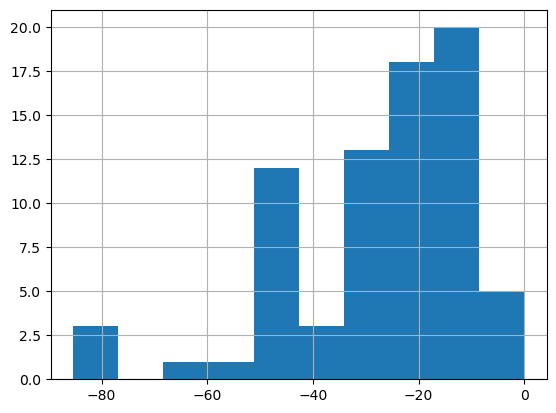

In [8]:
thaw_data['grad unfrozen C/m'].hist()

<Axes: >

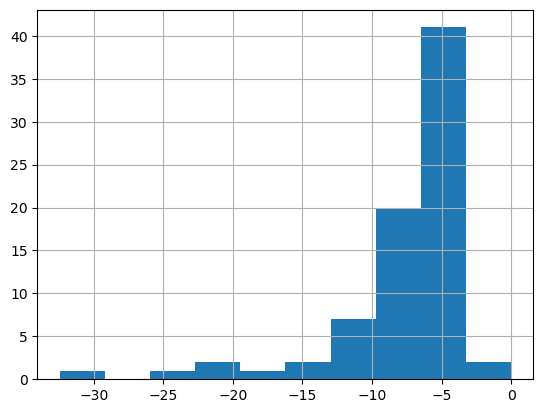

In [9]:
thaw_data['grad frozen C/m'].hist()